In [1]:
from lagrangian import LagrangianSolver
from dataclasses import dataclass

import torch
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from typing import Tuple

In [2]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rc('font', family='serif', serif="cmr10", size=18)
plt.rc('mathtext', fontset='cm', rm='serif')
plt.rc('axes', unicode_minus=False)

plt.rcParams['axes.formatter.use_mathtext'] = True

In [3]:
@dataclass
class Dzhanibekov(LagrangianSolver):
    R: float
    m1: float
    m2: float

    def T(self, u: torch.Tensor) -> torch.Tensor:
        (r1, r2, rdot1, rdot2) = u[1:].view(4, 3)
        return self.m1 * rdot1 @ rdot1 + self.m2 * rdot2 @ rdot2

    def constraints(self, u: torch.Tensor) -> Tuple[torch.Tensor]:
        (r1, r2, rdot1, rdot2) = u[1:].view(4, 3)
        return torch.stack([
            (r1 @ r1 - self.R**2),
            (r2 @ r2 - self.R**2),
            (r1 @ r2)
        ])

In [4]:
T = 50
N = 1000
t = torch.linspace(0,T,N)

r1 = torch.tensor([0., 0., 1.])
r2 = torch.tensor([1., 0., 0.])

omega = torch.tensor([0.0, 0.01, 1.]) # [rad/s]
u0 = torch.cat((
    r1, r2,
    torch.cross(omega, r1, dim=-1), torch.cross(omega, r2, dim=-1)
)).to(torch.float64)

solver = Dzhanibekov(R=1., m1=.1, m2=1.)
soln = solver.solve(u0, t)

100%|██████████| 999/999 [00:19<00:00, 50.25it/s]


In [5]:
import numpy as np

x1,y1,z1, x2,y2,z2, xdot1,ydot1,zdot1, xdot2,ydot2,zdot2 = soln['u'].T

x1, y1, z1 = map(np.ravel, (x1, y1, z1))
x2, y2, z2 = map(np.ravel, (x2, y2, z2))

fig = plt.figure(figsize=(10.8, 10.8))
ax = fig.add_subplot(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

ax.grid(False)
ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])
ax.set_zticks([-1,0,1])

ax.set_xlabel('$x$ / m')
ax.set_ylabel('$y$ / m')
ax.set_zlabel('$z$ / m')
# ax.set_title('$z$ / m')

trail1, = ax.plot([], [], [], lw=4, alpha=.2)
trail2, = ax.plot([], [], [], lw=4, alpha=.2)

body1, = ax.plot([], [], [], 'C0o-', ms=16, lw=4)
body2, = ax.plot([], [], [], 'C1o-', ms=16, lw=4)


def animate(i):
    idx = min(2*i, len(t))
    trail1.set_data(x1[:idx], y1[:idx])
    trail1.set_3d_properties(z1[:idx])

    body1.set_data([x1[idx], -x1[idx]], [y1[idx], -y1[idx]])
    body1.set_3d_properties([z1[idx], -z1[idx]])

    trail2.set_data(x2[:idx], y2[:idx])
    trail2.set_3d_properties(z2[:idx])

    body2.set_data([x2[idx], -x2[idx]], [y2[idx], -y2[idx]])
    body2.set_3d_properties([z2[idx], -z2[idx]])

    return (trail1,)

ani = animation.FuncAnimation(fig, animate, frames=len(t)//2, blit=True)

plt.close()
# HTML(ani.to_jshtml())
ani.save('./assets/Dzhanibekov.mp4', writer="ffmpeg", fps=60, dpi=100)

In [6]:
r1, r2, rdot1, rdot2 = soln['u'].view(len(t), 4, 3).transpose(0, 1)

lambda1, lambda2, lambda3 = torch.zeros((3, len(t)), dtype=float)

for i in range(N):
    lambda1[i] = -solver.m1/solver.R**2 * rdot1[i] @ rdot1[i]
    lambda2[i] = -solver.m2/solver.R**2 * rdot2[i] @ rdot2[i]
    lambda3[i] = -4*(rdot1[i] @ rdot2[i])/solver.R**2 * solver.m1*solver.m2/(solver.m1+solver.m2)

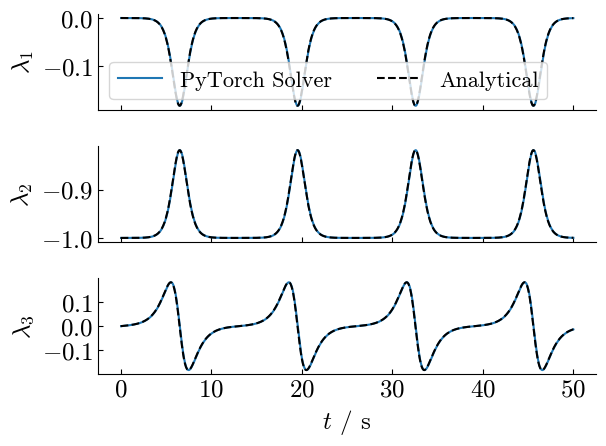

In [7]:
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(t[1:], soln['lambdas'][1:,0], 'C0', label='PyTorch Solver')
ax[0].plot(t, lambda1, 'k--', label='Analytical')
ax[0].set_ylabel('$\lambda_1$')

ax[1].plot(t[1:], soln['lambdas'][1:,1], 'C0')
ax[1].plot(t, lambda2, 'k--')
ax[1].set_ylabel('$\lambda_2$')

ax[2].plot(t[1:], soln['lambdas'][1:,2], 'C0')
ax[2].plot(t, lambda3, 'k--')
ax[2].set_ylabel('$\lambda_3$')

ax[0].legend(ncols=2, fontsize=16)

ax[2].set_xlabel('$t$ / s')
fig.tight_layout()
fig.savefig('./assets/Dzhanibekov-multipliers.svg')